In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [2]:
# batch_size = 512

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root="../../../datasets", train=True, transform=transform, download=True)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_data = train_dataset.data
train_labels = train_dataset.targets
print("train: ", train_data.shape)
print("train: ", train_labels.shape)

test_dataset = torchvision.datasets.MNIST(root="../../../datasets", train=False, transform=transform, download=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)
test_data = test_dataset.data
test_labels = test_dataset.targets
print("test: ", test_data.shape)
print("train: ", test_labels.shape)

train:  torch.Size([60000, 28, 28])
train:  torch.Size([60000])
test:  torch.Size([10000, 28, 28])
train:  torch.Size([10000])


In [4]:
class MultiModalAutoencoder(nn.Module):
    def __init__(self, **kwargs):
        super(MultiModalAutoencoder, self).__init__()
        
        self.num_of_domains = kwargs["num_of_domains"]
        self.num_of_features = kwargs["num_of_features"]
        self.hidden_layer_sizes = kwargs["hidden_layer_sizes"]
        self.activation_fn = kwargs["activation_fn"]
        self.decoder_input_size = self.hidden_layer_sizes[-1] * self.num_of_domains
        print("self.decoder_input_size: ", self.decoder_input_size)
        
        for domain_idx in range(self.num_of_domains):
            
            # encoder
            encoder_layers = []
            encoder_layers.append(nn.Linear(in_features=self.num_of_features[domain_idx], out_features=self.hidden_layer_sizes[0]))
            encoder_layers.append(self.activation_fn(inplace=True))
            for i in range(1, len(self.hidden_layer_sizes)):
                encoder_layers.append(nn.Linear(in_features=self.hidden_layer_sizes[i-1], out_features=self.hidden_layer_sizes[i]))
                encoder_layers.append(self.activation_fn(inplace=True))
            exec("self.encoder%d = %s" % (domain_idx, "nn.Sequential(*encoder_layers)"))

            # decoder
            decoder_layers = []
            decoder_layers.append(nn.Linear(in_features=self.decoder_input_size, out_features=self.hidden_layer_sizes[-2]))
            decoder_layers.append(self.activation_fn(inplace=True))
            for i in range(len(self.hidden_layer_sizes)-2, 0, -1):
                decoder_layers.append(nn.Linear(in_features=self.hidden_layer_sizes[i], out_features=self.hidden_layer_sizes[i-1]))
                decoder_layers.append(self.activation_fn(inplace=True))
            decoder_layers.append(nn.Linear(in_features=self.hidden_layer_sizes[i-1], out_features=self.num_of_features[domain_idx]))
            decoder_layers.append(self.activation_fn(inplace=True))
            exec("self.decoder%d = %s" % (domain_idx, "nn.Sequential(*decoder_layers)"))
        
    def forward(self, domains_data):
                
        encoder_outputs = self.generate_code(domains_data)
        
        predictions = {}
        for domain_idx in range(self.num_of_domains):
            exec("self.decoder_output = self.decoder%d(encoder_outputs)" % (domain_idx))
            predictions["domain_"+str(domain_idx)] = self.decoder_output
            
        return predictions
    
    def generate_code(self, domains_data):
        
        encoder_outputs = self.encoder0(domains_data["domain_0"])
        for domain_idx in range(1, self.num_of_domains):
            exec("self.encoder_output = self.encoder%d(domains_data[\"domain_%s\"])" % (domain_idx, domain_idx))
            encoder_outputs= torch.cat([encoder_outputs, self.encoder_output], dim=1)
            
        return encoder_outputs


In [5]:
num_of_features = [784, 784] # [784, 784]
num_of_domains = len(num_of_features)
HIDDEN_LAYER_UNITS = [256, 128, 64]
ACTIVATION_FUNCTION = nn.ReLU  # nn.ELU, nn.ReLU

learning_rate = 1e-3

In [6]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = MultiModalAutoencoder(num_of_domains=num_of_domains,
                    num_of_features=num_of_features,
                    hidden_layer_sizes=HIDDEN_LAYER_UNITS,
                   activation_fn=ACTIVATION_FUNCTION)
model = model.to(device)
print("model: ", model)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print("optimizer: ", optimizer)

# mean-squared error loss
criterion = nn.MSELoss()
print("criterion: ", criterion)

device:  cuda
self.decoder_input_size:  128
model:  MultiModalAutoencoder(
  (encoder0): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder0): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): ReLU(inplace=True)
  )
  (encoder1): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder1): Sequential(
 

In [7]:
def get_labels_names_dict(labels_names, examples_per_class):
    labels_names_dict = {}

    for example_i, example_label in enumerate(labels_names):
        example_label = example_label.item()
        labels_names_dict.setdefault(example_label, [])
        if len(labels_names_dict[example_label]) < examples_per_class:
            labels_names_dict[example_label].append(example_i)
        
    return labels_names_dict

def get_domains_data(data, num_of_domains, labels_names_dict):
    domains_data = {}
    domains_label = {}

    for a_domain in range(num_of_domains):
        x_data = []
        x_label = []
        for a_label in sorted(labels_names_dict.keys()):
            # print(a_label)
            example_i_list = labels_names_dict[a_label]
            np.random.shuffle(example_i_list)

            x_data.extend(data[example_i_list].view(-1, 784).numpy())
            x_label.extend(np.repeat(a_label, len(data[example_i_list])))

        domains_data['domain_'+str(a_domain)] = np.array(x_data)
        domains_label['domain_'+str(a_domain)] = np.array(x_label)
    
    return domains_data, domains_label

In [8]:
examples_per_class = 5000

train_labels_names_dict = get_labels_names_dict(train_labels, examples_per_class)
domains_data_train, domains_label_train = get_domains_data(train_data, num_of_domains, train_labels_names_dict)

In [9]:
for domain in domains_data_train:
    domains_data_train[domain] = torch.from_numpy(domains_data_train[domain]).to(device).float()
    
    print(domain, domains_data_train[domain].shape)
    print(domain, domains_label_train[domain].shape, domains_label_train[domain][0:10])
    print("")

domain_0 torch.Size([50000, 784])
domain_0 (50000,) [0 0 0 0 0 0 0 0 0 0]

domain_1 torch.Size([50000, 784])
domain_1 (50000,) [0 0 0 0 0 0 0 0 0 0]



In [10]:
epochs = 20
batch_size = 512

cost_log = []
for epoch in range(epochs):
    
    # shuffling
    random_idx = torch.randperm(domains_label_train['domain_0'].shape[0])
    for domain in domains_data_train:
        domains_data_train[domain] = domains_data_train[domain][random_idx]
        domains_label_train[domain] = domains_label_train[domain][random_idx]
        
    loss = 0
    for i in range(batch_size, domains_data_train['domain_0'].shape[0]+1, batch_size):
        
        domains_data_train_temp = {}
        for domain in domains_data_train:
            domains_data_train_temp[domain] = domains_data_train[domain][i-batch_size:i]
                
        # compute reconstructions
        outputs = model(domains_data_train_temp)

        # compute training reconstruction loss
        train_loss = 0
        for domain in outputs:
            train_loss += criterion(outputs[domain], domains_data_train_temp[domain])

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / (domains_data_train['domain_0'].shape[0]//batch_size)
    cost_log.append(loss)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
    
    # Print generated data after every 100 epoch
    if (epoch + 1) % 100 == 0:
        example = np.random.randint(len(domains_data_train[domain]), size=1)
        print("Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(loss))
        
        for domain in range(num_of_domains):
            # print("domain: ", domain)
            fig, all_plots = plt.subplots(1, 2, figsize=(4, 4))

            canvas_orig = domains_data_train['domain_'+str(domain)][example].cpu().numpy().reshape(28, 28)
            all_plots[0].set_title(str(domain)+" Original")
            all_plots[0].imshow(canvas_orig, origin="upper", cmap="gray")

            canvas_recon = outputs['domain_'+str(domain)][example].cpu().detach().numpy().reshape(28, 28)
            all_plots[1].set_title(str(domain)+" Generated")
            all_plots[1].imshow(canvas_recon, origin="upper", cmap="gray")
        
        plt.show()

epoch : 1/20, recon loss = 8814.49943621
epoch : 2/20, recon loss = 5461.00072990
epoch : 3/20, recon loss = 4362.17665462
epoch : 4/20, recon loss = 3883.81836189
epoch : 5/20, recon loss = 3525.45925368
epoch : 6/20, recon loss = 3293.71802765
epoch : 7/20, recon loss = 3141.68917878
epoch : 8/20, recon loss = 2993.14872443
epoch : 9/20, recon loss = 2861.25215700
epoch : 10/20, recon loss = 2749.96846307
epoch : 11/20, recon loss = 2666.44429315
epoch : 12/20, recon loss = 2598.94116463
epoch : 13/20, recon loss = 2539.71465498
epoch : 14/20, recon loss = 2494.44507843
epoch : 15/20, recon loss = 2445.73459901
epoch : 16/20, recon loss = 2407.57971317
epoch : 17/20, recon loss = 2370.11988060
epoch : 18/20, recon loss = 2331.72512786
epoch : 19/20, recon loss = 2289.48014407
epoch : 20/20, recon loss = 2255.29526166


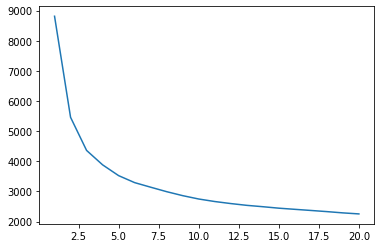

In [11]:
plt.plot(range(1, len(cost_log)+1), cost_log)
plt.show()

In [12]:
test_labels_names_dict = get_labels_names_dict(test_labels, examples_per_class)
domains_data_test, domains_label_test = get_domains_data(test_data, num_of_domains, test_labels_names_dict)

for domain in domains_data_train:
    domains_data_test[domain] = torch.from_numpy(domains_data_test[domain]).to(device).float()
    
    print(domain, domains_data_test[domain].shape)
    print(domain, domains_data_test[domain].shape)
    print("")

domain_0 torch.Size([10000, 784])
domain_0 torch.Size([10000, 784])

domain_1 torch.Size([10000, 784])
domain_1 torch.Size([10000, 784])



In [13]:
with torch.no_grad():
    
    outputs = model(domains_data_test)
    code = model.generate_code(domains_data_test).cpu().numpy()
    labels = domains_label_test["domain_0"]

In [14]:
for domain in outputs:
    print(domain, outputs[domain].shape)

print("code.shape: ", code.shape)
print("labels.shape: ", labels.shape)

domain_0 torch.Size([10000, 784])
domain_1 torch.Size([10000, 784])
code.shape:  (10000, 128)
labels.shape:  (10000,)


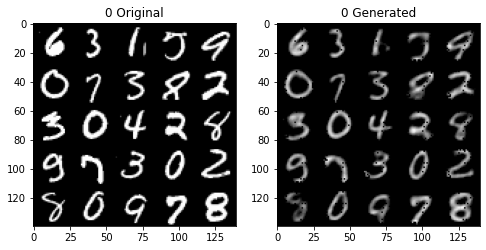

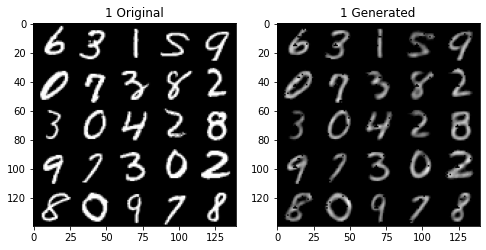

In [15]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 5
examples = np.random.randint(len(domains_data_test["domain_0"]), size=n*n)

for domain in range(num_of_domains):
    canvas_orig = np.empty((28 * n, 28 * n))
    canvas_recon = np.empty((28 * n, 28 * n))
    fig, all_plots = plt.subplots(1, 2, figsize=(8, 8))
    for i in range(n):        
        # Display original images
        for j, example in zip(range(n), examples[i*n:i*n+n]):
            # Draw the generated digits
            canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = domains_data_test['domain_'+str(domain)][example].cpu().reshape([28, 28])
        # Display reconstructed images
        for j, example in zip(range(n), examples[i*n:i*n+n]):
            # Draw the generated digits
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = outputs['domain_'+str(domain)][example].cpu().reshape([28, 28])

    all_plots[0].set_title(str(domain)+" Original")
    all_plots[0].imshow(canvas_orig, origin="upper", cmap="gray")

    all_plots[1].set_title(str(domain)+" Generated")
    all_plots[1].imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()

In [16]:
g_embedded = PCA(n_components=2).fit_transform(code)

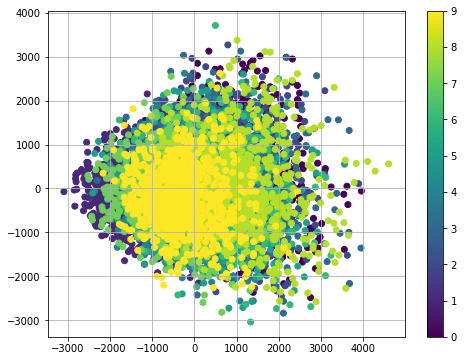

In [17]:
plt.figure(figsize=(8, 6)) 
plt.scatter(g_embedded[:, 0], g_embedded[:, 1], c=labels, cmap='viridis')
plt.colorbar()
plt.grid()